In [198]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [199]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [200]:
plt.style.use('science')
sns.set_theme()

plt.rcParams['figure.figsize'] = (8, 4)

## Загрузка данных

In [201]:
df: pd.DataFrame = pd.read_csv('data/cars_sampled.csv')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
0,30/03/2016 13:51,Zu_verkaufen,private,offer,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,NaN,30/03/2016 0:00,20257,7/4/2016 4:44
1,7/3/2016 9:54,Volvo_XC90_2.4D_Summum,private,offer,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,no,7/3/2016 0:00,88045,26/03/2016 13:17
2,1/4/2016 0:57,Volkswagen_Touran,private,offer,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,NaN,31/03/2016 0:00,27449,1/4/2016 8:40
3,19/03/2016 17:50,Seat_Ibiza_1.4_16V_Reference,private,offer,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,no,19/03/2016 0:00,34537,7/4/2016 4:44
4,16/03/2016 14:51,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,no,16/03/2016 0:00,55270,1/4/2016 23:18


## Описательная статистика

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dateCrawled          50001 non-null  object
 1   name                 50001 non-null  object
 2   seller               50001 non-null  object
 3   offerType            50001 non-null  object
 4   price                50001 non-null  int64 
 5   abtest               50001 non-null  object
 6   vehicleType          44813 non-null  object
 7   yearOfRegistration   50001 non-null  int64 
 8   gearbox              47177 non-null  object
 9   powerPS              50001 non-null  int64 
 10  model                47243 non-null  object
 11  kilometer            50001 non-null  int64 
 12  monthOfRegistration  50001 non-null  int64 
 13  fuelType             45498 non-null  object
 14  brand                50001 non-null  object
 15  notRepairedDamage    40285 non-null  object
 16  date

In [203]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,postalCode
count,5.000100e+04,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000
mean,6.559865e+03,2005.544229,116.496130,125613.687726,5.743725,50775.216696
std,8.581847e+04,122.991832,230.567709,40205.234483,3.711345,25743.701933
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1.150000e+03,1999.000000,69.000000,125000.000000,3.000000,30559.000000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,49504.000000
75%,7.190000e+03,2008.000000,150.000000,150000.000000,9.000000,71404.000000
max,1.234568e+07,9999.000000,19312.000000,150000.000000,12.000000,99998.000000


## Исправление датасета

In [204]:
tidy = df.copy()

Даты `dateCrawled, dateCreated, lastSeen` в исходном наборе представлены строками в формате ``.

И хотя вряд ли, эти даты можно будет эффективно использовать в модели регрессии, приведем их к типу `datetime64` _(потому что можем, и хотим показать умение работать с датами)_

In [205]:
date_cols = ['dateCrawled', 'dateCreated', 'lastSeen']
tidy[date_cols] = tidy[date_cols].apply(lambda s: pd.to_datetime(s, format='%d/%m/%Y %H:%M'))
tidy[date_cols].dtypes

dateCrawled    datetime64[ns]
dateCreated    datetime64[ns]
lastSeen       datetime64[ns]
dtype: object

Проведем работы на целевой переменной `price`. Попытаемся привести ее к нормальному распределению.

In [206]:
price = tidy['price']
len(price), price.min(), price.max()

(50001, 0, 12345678)

`0` явно является некорректным значением для цены. От всех строк, содержащих 0 в поле `price` придется избавиться.

_`1` и другие слишком низкие значения, возможно тоже не характерны для цены._

In [207]:
price[price < price.quantile(0.1)].value_counts().sort_index()[:20]

0     1451
1      172
2        1
3        1
5        4
7        1
8        2
10       5
11       1
12       1
14       1
15       8
20       6
21       1
25       5
26       1
30       7
35       4
39       1
40       3
Name: price, dtype: int64

In [208]:
price_ = price[price > 10]
len(price_)

48364

In [209]:
tidy: pd.DataFrame = tidy.loc[price_.index]
tidy['price'] = price_
tidy.shape

(48364, 19)

Попробуем построить гистограмму распределения `price`:

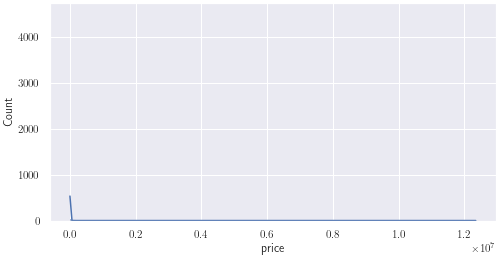

In [210]:
sns.histplot(x=price_, kde=True);

Разбег шкалы и сильная смещенность распределения данных не позволяют получить читабельную визуализацию.



In [211]:
pd.Series(price_).value_counts(bins=10)

(-12334.668, 1234577.7]     48359
(9876544.6, 11111111.3]         2
(1234577.7, 2469144.4]          1
(2469144.4, 3703711.1]          1
(11111111.3, 12345678.0]        1
(3703711.1, 4938277.8]          0
(4938277.8, 6172844.5]          0
(6172844.5, 7407411.2]          0
(7407411.2, 8641977.9]          0
(8641977.9, 9876544.6]          0
Name: price, dtype: int64

В таком случае очень полезным оказываются свойства функции логарифма. Попробуем прологарифмировать значение цены:

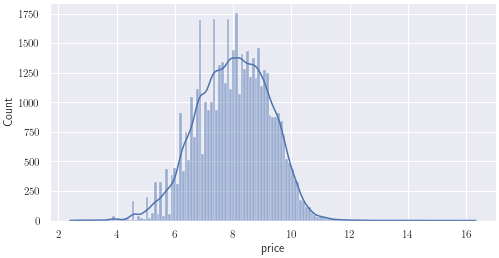

In [212]:
price_ = np.log(price_)
sns.histplot(x=price_, kde=True);

Ну вот... и распределение получилось близким к нормальному.

С помощью ящика с усами можно наглядно увидеть присутствие выбросов и границы, в которых сосредоточена большая часть данных.

(2.3978952727983707, 16.32881660027397)

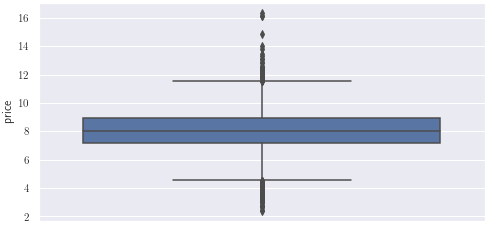

In [213]:
sns.boxplot(y=price_)
price_.min(), price_.max()

Выбросы представлены значениями, лежащими выше (\~)11 и ниже (\~)5.

Избавимся от выбросов с помощью IQR:

In [214]:
q_1, q_3 = price_.quantile([0.25, 0.75])
iqr = q_3 - q_1
left = q_1 - 1.5 * iqr
right = q_3 + 1.5 * iqr
print(
    f'Q1 = {q_1:.2f}, Q3 = {q_3:.2f}\n'
    f'IQR = {iqr:.2f}\n'
    f'[{left:.2f};{right:.2f}]'
)

price_ = price_[(price_ > left) & (price_ < right)]
len(price_)

Q1 = 7.16, Q3 = 8.92
IQR = 1.76
[4.52;11.56]


48179

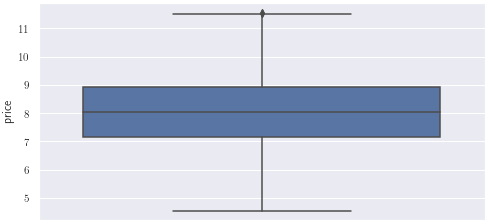

In [215]:
sns.boxplot(y=price_);

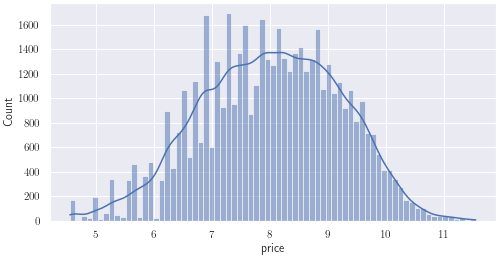

In [216]:
sns.histplot(x=price_, kde=True);

Вот теперь получилось красиво.

In [217]:
tidy: pd.DataFrame = tidy.loc[price_.index]
tidy['adj_price'] = price_
tidy.shape

(48179, 20)

### Числовые признаки

Улучшим несколько потенциально наиболее важных для `price` числовых признаков.

In [218]:
def drop_iqr(s: pd.Series) -> pd.Series:
    q_1, q_3 = s.quantile([0.25, 0.75])
    iqr = q_3 - q_1
    return s[(s > q_1 - 1.5 * iqr) & (s < q_3 + 1.5 * iqr)]

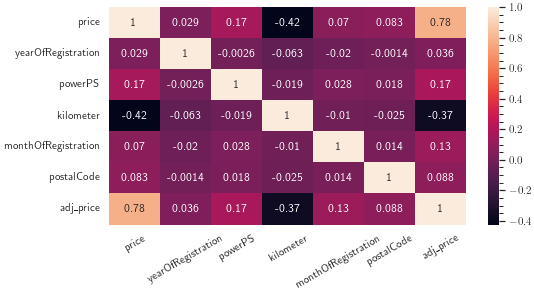

In [219]:
ax = sns.heatmap(tidy.corr(), annot=True)
ax.tick_params(axis='x', rotation=30)

На основе матрицы корреляций можно выделить 2 наиболее коррелирующих с целевой переменной признака: `kilometer`, `powerPS`.

Применим к `kilometer` те же техники исправления, что и к `price`.

In [220]:
kilometer = tidy['kilometer']
len(kilometer), kilometer.min(), kilometer.max()

(48179, 5000, 150000)

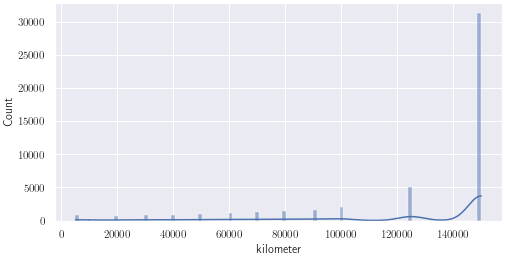

In [221]:
sns.histplot(x=kilometer, kde=True);

(5000, 150000)

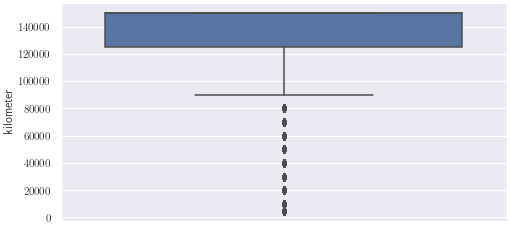

In [222]:
sns.boxplot(y=kilometer)
kilometer.min(), kilometer.max()

In [223]:
kilometer_ = drop_iqr(kilometer)
len(kilometer_)

39900

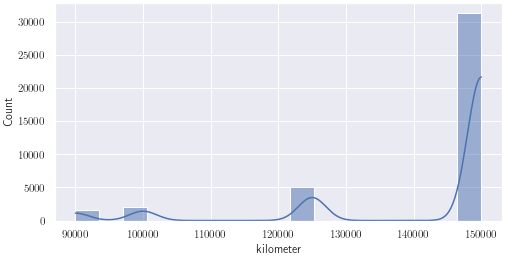

In [224]:
sns.histplot(x=kilometer_, kde=True);

(90000, 150000)

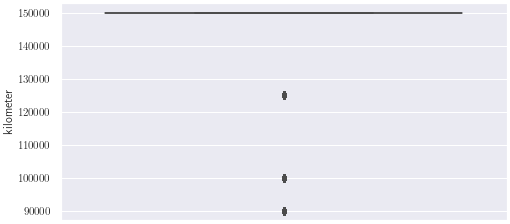

In [225]:
sns.boxplot(y=kilometer_)
kilometer_.min(), kilometer_.max()

Сделали все правильно (вроде как), но что-то пошло не так. Предположительно, это связано с категориальной природой `kilometer` и с особенностью его распределения, где доминирует один клас (140000 - 160000).

Принято решение не изменять `kilometer` и подставить под сомнение его использование в качестве признака.

Применим к `powerPS` те же техники исправления, что и к `price` и `kilometer`.

_Но техники уже не те, ведь теперь хороши они лишь на 50%_

In [226]:
power_ps = tidy['powerPS']
print(len(power_ps))
print(pd.Series(power_ps.unique()).nsmallest(5).tolist())
print(power_ps.nlargest(5).tolist())

48179
[0, 1, 2, 3, 4]
[19312, 19211, 16312, 16011, 15033]


`0` явно не характерен для `powerPS`. Удалим все строки содержащие `0` в столбце `powerPS`:

In [227]:
power_ps_ = power_ps[power_ps > 0]

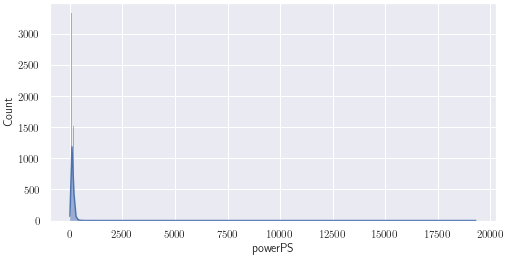

In [228]:
sns.histplot(x=power_ps_, kde=True);

In [229]:
power_ps_ = np.log(power_ps_)

(0.0, 9.868481943337313)

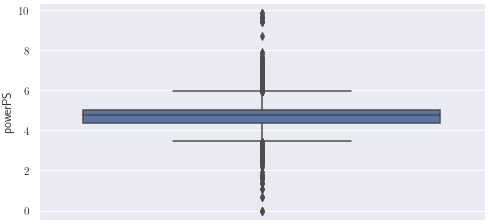

In [230]:
sns.boxplot(y=power_ps_)
power_ps_.min(), power_ps_.max()

In [231]:
power_ps_ = drop_iqr(power_ps_)
len(power_ps_)

42851

(3.4657359027997265, 5.953243334287785)

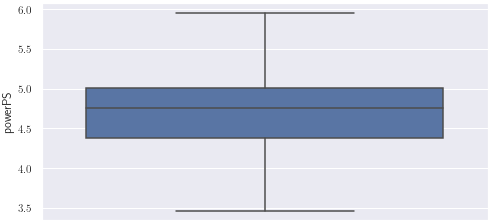

In [232]:
sns.boxplot(y=power_ps_)
power_ps_.min(), power_ps_.max()

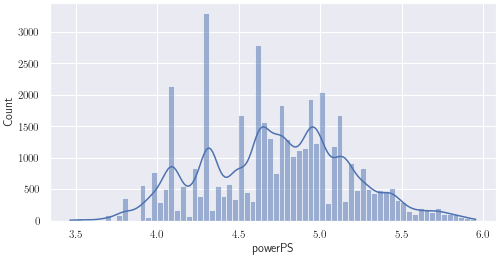

In [233]:
sns.histplot(x=power_ps_, kde=True);

In [234]:
tidy: pd.DataFrame = tidy.loc[power_ps_.index]
tidy['adj_powerPS'] = power_ps_
tidy.shape

(42851, 21)

In [235]:
tidy[['price', 'adj_price', 'powerPS', 'adj_powerPS', 'kilometer']].corr()[['price', 'adj_price']]

,price,adj_price
price,1.000000,0.800226
adj_price,0.800226,1.000000
powerPS,0.557621,0.561272
adj_powerPS,0.517052,0.574885
kilometer,-0.458463,-0.412513


Пересчет корреляций с исправленными признаками показал, что:
1. время потрачено не зря
2. время потрачено впустую

### Нечисловые признаки

Посмотрим на шкалы доступных (разумных) нечисловых признаков:

In [236]:
print('Шкалы нечисловых данных:')
print(f'gearbox: {tidy["gearbox"].unique().tolist()}')
print(f'fuelType: {tidy["fuelType"].unique().tolist()}')
print(f'vehicleType: {tidy["vehicleType"].unique().tolist()}')
print(f'notRepairedDamage: {tidy["notRepairedDamage"].unique().tolist()}')

Шкалы нечисловых данных:
gearbox: ['manual', 'automatic', nan]
fuelType: ['diesel', 'petrol', nan, 'cng', 'lpg', 'hybrid', 'other', 'electro']
vehicleType: ['limousine', 'suv', 'bus', 'small car', 'coupe', 'station wagon', nan, 'others', 'cabrio']
notRepairedDamage: [nan, 'no', 'yes']


Из увиденного можно сделать вывод, что все нечисловые признаки являются категориальными.

Построим ящиковые диаграммы зависимости рассматриваемых признаков от `adj_price`:

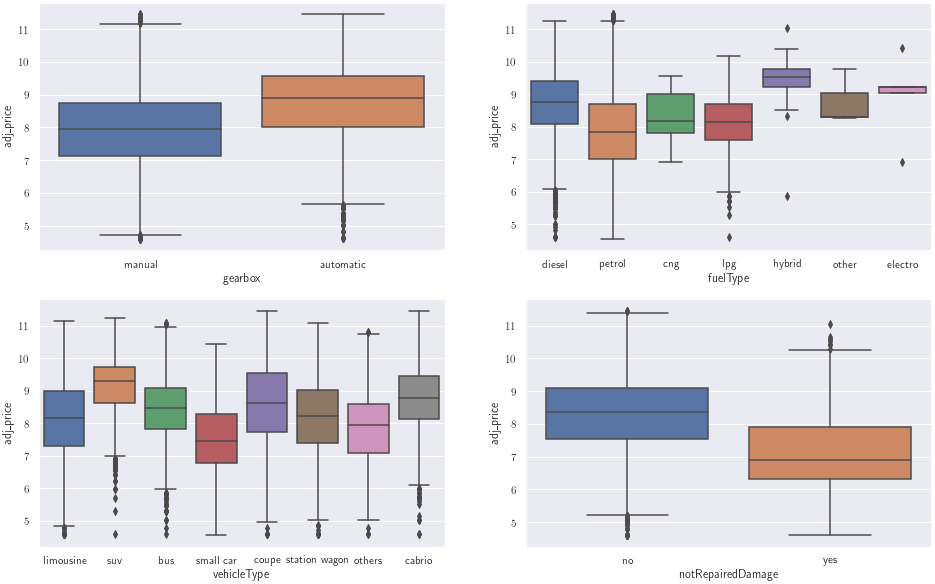

In [237]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for ax, col in zip(axes.flatten(), ['gearbox', 'fuelType', 'vehicleType', 'notRepairedDamage']):
    sns.boxplot(data=tidy, x=col, y='adj_price', ax=ax)

Графики наглядно демонстрируют категории с выбросами, а также можно выделить некоторые закономерности по ценовым сегментам:
1) автомобили с автоматической коробкой передач в среднем дороже автомобилей с механикой
2) электромобили и автомобили с гибридным типом потребления топлива стоят дороже, чем автомобили с бензиновым двигателем. Но автомобилей с бензиновым двигателем гораздо больше
3) автомобили без повреждений дороже восстановленных автомобилей

In [238]:
tidy['gearbox'].value_counts()

manual       32731
automatic     9336
Name: gearbox, dtype: int64

In [239]:
print(list(tidy['fuelType'].value_counts().items()))

[('petrol', 26449), ('diesel', 13020), ('lpg', 688), ('cng', 71), ('hybrid', 36), ('electro', 5), ('other', 3)]


В распределении `fuelType` есть два доминирующих класса: `petrol`, `diesel`, и несколько маленьких категорий.

Обобщим значения с низкой частотой до категории `other`:

In [240]:
fuel_type = tidy['fuelType'].copy()
fuel_type[fuel_type.isin(['lpg', 'cng', 'hybrid', 'electro'])] = 'other'
tidy['fuelType'] = fuel_type

In [241]:
print(list(tidy['vehicleType'].value_counts().items()))

[('limousine', 11773), ('small car', 9337), ('station wagon', 8124), ('bus', 3623), ('cabrio', 2760), ('coupe', 2206), ('suv', 1829), ('others', 323)]


У `vehicleType` доминация чуть менее выражена, присутствует лишь один класс `other`,
который совершенно не сопоставим с остальными.

Заменим его на моду - `limousine`:

In [242]:
vehicle_type = tidy['vehicleType'].copy()
vehicle_type[vehicle_type == 'others'] = 'limousine'
tidy['vehicleType'] = vehicle_type

In [243]:
tidy['notRepairedDamage'].value_counts()

no     32575
yes     4002
Name: notRepairedDamage, dtype: int64

### Работа с оставшимися пропусками

Посмотрим на оставшиеся пропуски в датасете. Для удобства добавим их процентный вклад в общее количество примеров признака:

In [244]:
na = tidy.isna().sum()
print(f'n: {len(tidy)}')
na = na[na > 0]
na = pd.concat([na, na / len(tidy) * 100], axis=1)
na.columns = ['n', '%']
na

n: 42851


,n,%
vehicleType,2876,6.711629
gearbox,784,1.829596
model,1644,3.836550
fuelType,2579,6.018529
notRepairedDamage,6274,14.641432


Почти 15% - довольно большая доля пропусков. Восстановление с помощью среднего может вызвать большое смешение распределения, поэтому просто удалим эти строки:

In [245]:
tidy: pd.DataFrame = tidy.drop(columns=['notRepairedDamage'])

In [246]:
print('Шкалы нечисловых данных:')
print(f'vehicleType: {tidy["vehicleType"].unique().tolist()}')
print(f'gearbox: {tidy["gearbox"].unique().tolist()}')
print(f'model: {str(tidy["model"].unique().tolist()[:10])[:-1]}, ...]')
print(f'fuelType: {tidy["fuelType"].unique().tolist()}')

Шкалы нечисловых данных:
vehicleType: ['limousine', 'suv', 'bus', 'small car', 'coupe', 'station wagon', nan, 'cabrio']
gearbox: ['manual', 'automatic', nan]
model: ['3er', 'xc_reihe', 'touran', 'ibiza', 'passat', 'clk', 'vectra', 'octavia', 'a_klasse', 'astra', ...]
fuelType: ['diesel', 'petrol', nan, 'other']


Оставшиеся пропуски восстановим с помощью моды:

In [247]:
cols = ['vehicleType', 'gearbox', 'model', 'fuelType']
tidy[cols] = tidy[cols].fillna('mode')

Сохраним получившийся (надеюсь, что чистый) датасет:

In [248]:
tidy.to_csv('out/tidy.csv', index=False)

In [249]:
df = pd.read_csv('out/tidy.csv')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,dateCreated,postalCode,lastSeen,adj_price,adj_powerPS
0,2016-03-30 13:51:00,Zu_verkaufen,private,offer,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,2016-03-30,20257,2016-04-07 04:44:00,8.400659,5.010635
1,2016-03-07 09:54:00,Volvo_XC90_2.4D_Summum,private,offer,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,2016-03-07,88045,2016-03-26 13:17:00,9.495444,5.093750
2,2016-04-01 00:57:00,Volkswagen_Touran,private,offer,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,2016-03-31,27449,2016-04-01 08:40:00,8.070906,4.615121
3,2016-03-19 17:50:00,Seat_Ibiza_1.4_16V_Reference,private,offer,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,2016-03-19,34537,2016-04-07 04:44:00,8.411833,4.454347
4,2016-03-16 14:51:00,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,2016-03-16,55270,2016-04-01 23:18:00,9.838949,5.220356


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42851 entries, 0 to 42850
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dateCrawled          42851 non-null  object 
 1   name                 42851 non-null  object 
 2   seller               42851 non-null  object 
 3   offerType            42851 non-null  object 
 4   price                42851 non-null  int64  
 5   abtest               42851 non-null  object 
 6   vehicleType          42851 non-null  object 
 7   yearOfRegistration   42851 non-null  int64  
 8   gearbox              42851 non-null  object 
 9   powerPS              42851 non-null  int64  
 10  model                42851 non-null  object 
 11  kilometer            42851 non-null  int64  
 12  monthOfRegistration  42851 non-null  int64  
 13  fuelType             42851 non-null  object 
 14  brand                42851 non-null  object 
 15  dateCreated          42851 non-null 

## Дополнительное задание. Модель регрессии для цены автомобиля

На наших "ну таких себе" данных:

In [251]:
X = df[['powerPS', 'kilometer', 'gearbox', 'fuelType', 'vehicleType']]
y = df[['price']]

In [252]:
enc = OneHotEncoder()
X_bin = enc.fit_transform(X[['gearbox', 'fuelType', 'vehicleType']])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['powerPS', 'kilometer']])

X = pd.concat([pd.DataFrame(X_bin.toarray()), pd.DataFrame(X_scaled)], ignore_index=True, axis=1)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [254]:
reg = LinearRegression()
reg.fit(X_train, y_train);

In [255]:
print(f'R2: {reg.score(X_test, y_test):.4f}')

R2: 0.5760


На наших "лучших" данных

In [273]:
X = df[['adj_powerPS', 'kilometer', 'gearbox', 'fuelType', 'vehicleType']]
y = df[['adj_price']]

In [274]:
enc = OneHotEncoder()
X_bin = enc.fit_transform(X[['gearbox', 'fuelType', 'vehicleType']])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['adj_powerPS', 'kilometer']])

X = pd.concat([pd.DataFrame(X_bin.toarray()), pd.DataFrame(X_scaled), df[['monthOfRegistration']]], ignore_index=True, axis=1)

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [276]:
reg = LinearRegression()
reg.fit(X_train, y_train);

In [277]:
print(f'R2: {reg.score(X_test, y_test):.4f}')

R2: 0.5867


**Вывод:** уровень "простая предобработка" failed.